In [3]:
from google.colab import drive
import os

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Path to your .tgz file in Drive (change path if stored elsewhere)
tgz_path = "/content/drive/MyDrive/CUB_200_2011.tgz"

# 3️⃣ Extract the dataset into /content/
if os.path.exists(tgz_path):
    !tar -xzf "$tgz_path" -C /content/
else:
    raise FileNotFoundError(f"Dataset archive not found at: {tgz_path}")

# 4️⃣ Dataset directory root
DATA_DIR = "/content/CUB_200_2011"

# 5️⃣ Verify extraction
if os.path.exists(DATA_DIR):
    print("✅ Dataset ready at:", DATA_DIR)
    !ls "$DATA_DIR" | head
else:
    raise FileNotFoundError(f"Dataset folder not found at: {DATA_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset ready at: /content/CUB_200_2011
attributes
bounding_boxes.txt
classes.txt
image_class_labels.txt
images
images.txt
parts
README
train_test_split.txt


In [4]:
!pip install -q torch torchvision transformers timm accelerate peft scikit-learn matplotlib pillow tqdm


In [5]:
import os, math, random, json
from pathlib import Path
from collections import defaultdict

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm

from transformers import ViTForImageClassification, AutoFeatureExtractor, get_scheduler
from peft import LoraConfig, get_peft_model, TaskType

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [6]:
def prepare_cub_imagefolder(data_root: str, out_dir: str):
    data_root = Path(data_root)
    images_txt = data_root / "images.txt"
    labels_txt = data_root / "image_class_labels.txt"
    split_txt = data_root / "train_test_split.txt"
    images_dir = data_root / "images"
    out_dir = Path(out_dir)
    train_folder, test_folder = out_dir / "train", out_dir / "test"
    for d in (train_folder, test_folder):
        d.mkdir(parents=True, exist_ok=True)

    id_to_path = {int(i): p for i, p in (line.split() for line in open(images_txt))}
    id_to_label = {int(i): int(l) - 1 for i, l in (line.split() for line in open(labels_txt))}
    id_to_split = {int(i): int(s) for i, s in (line.split() for line in open(split_txt))}

    for idx, rel in id_to_path.items():
        lbl, split = id_to_label[idx], id_to_split[idx]
        src = images_dir / rel
        dest_root = train_folder if split == 1 else test_folder
        label_dir = dest_root / f"class_{lbl:03d}"
        label_dir.mkdir(parents=True, exist_ok=True)
        os.symlink(src, label_dir / src.name) if not (label_dir / src.name).exists() else None

    return str(train_folder), str(test_folder)

train_folder, test_folder = prepare_cub_imagefolder(DATA_DIR, "./cub_imagefolder")
print("Prepared ImageFolder train:", train_folder)
print("Prepared ImageFolder test:", test_folder)


Prepared ImageFolder train: cub_imagefolder/train
Prepared ImageFolder test: cub_imagefolder/test


In [7]:
from torchvision import transforms

MODEL_NAME = "google/vit-base-patch16-224-in21k"
IMAGE_SIZE, BATCH_SIZE, NUM_WORKERS = 224, 32, 2

feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_NAME)
train_tfm = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7, 1.0)),
    transforms.ColorJitter(0.2,0.2,0.2,0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])
test_tfm = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

train_ds = ImageFolder(train_folder, transform=train_tfm)
test_ds  = ImageFolder(test_folder, transform=test_tfm)
val_frac = 0.1
val_size = int(len(train_ds)*val_frac)
train_set, val_set = torch.utils.data.random_split(train_ds, [len(train_ds)-val_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

num_classes = len(train_ds.classes)
print(f"Train {len(train_set)} | Val {len(val_set)} | Test {len(test_ds)} | Classes {num_classes}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Train 5395 | Val 599 | Test 5794 | Classes 200


In [11]:
# --- Cell: Model setup with correct LoRA target modules (fixed) ---
from peft import LoraConfig, get_peft_model, TaskType
import torch.nn as nn

MODEL_NAME = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(
    MODEL_NAME, num_labels=num_classes, ignore_mismatched_sizes=True
).to(DEVICE)

# Freeze everything first
for p in model.parameters():
    p.requires_grad = False

# Inspect named modules and locate the final encoder layer index (defensive)
encoder_names = [name for name, _ in model.named_modules() if "encoder.layer" in name]
if not encoder_names:
    raise RuntimeError("Couldn't find 'encoder.layer' in model.named_modules() — model structure may differ.")

# Extract layer indices found and pick max
layer_indices = set()
for nm in encoder_names:
    parts = nm.split(".")
    for i, tok in enumerate(parts):
        if tok == "layer" and i + 1 < len(parts):
            try:
                layer_indices.add(int(parts[i + 1]))
            except:
                pass
final_layer_idx = max(layer_indices)
print("Detected final encoder.layer index:", final_layer_idx)

# Collect candidate linear modules inside that final layer
target_linear_modules = []
for name, module in model.named_modules():
    if f"encoder.layer.{final_layer_idx}" in name:
        # only include modules that are Linear (supported)
        if isinstance(module, nn.Linear) or module.__class__.__name__.lower().startswith("linear"):
            target_linear_modules.append(name)
        # also include Conv1D from transformers (pytorch_utils.Conv1D) if present
        if module.__class__.__name__ == "Conv1D":
            target_linear_modules.append(name)

print(f"Found {len(target_linear_modules)} exact linear modules inside final layer. Example names (first 30):")
for n in target_linear_modules[:30]:
    print("  ", n)

# If nothing exact found (shouldn't happen), fallback to substrings common in ViT
if len(target_linear_modules) == 0:
    print("No exact linear modules found inside final layer. Falling back to safe substrings.")
    lora_target_modules = ["query", "key", "value", "dense", "proj", "output"]
else:
    # Build a set of short substrings from the names for PEFT to match (PEFT matches substrings)
    # choose last token(s) that are likely to match module attribute names, e.g. 'query', 'key', 'value', 'dense'
    substrings = set()
    for full_name in target_linear_modules:
        last = full_name.split(".")[-1]
        substrings.add(last)
        # also include last two tokens if helpful
        toks = full_name.split(".")
        if len(toks) >= 2:
            substrings.add(".".join(toks[-2:]))
    lora_target_modules = sorted(list(substrings))
    print("Using these target substrings for LoRA (PEFT substring-matching):", lora_target_modules)

# Configure LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=lora_target_modules,  # must be substrings that match actual Linear modules
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_CLS,  # classification-like task
)

# Apply LoRA
model = get_peft_model(model, lora_config)
model.to(DEVICE)

# Quick sanity prints
print("\n--- LoRA applied. Trainable parameters info ---")
model.print_trainable_parameters()

def count_trainable_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print("Total parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable parameters:", count_trainable_params(model))
print("Trainable fraction: {:.6f}".format(count_trainable_params(model) / sum(p.numel() for p in model.parameters())))


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Detected final encoder.layer index: 11
Found 6 exact linear modules inside final layer. Example names (first 30):
   vit.encoder.layer.11.attention.attention.query
   vit.encoder.layer.11.attention.attention.key
   vit.encoder.layer.11.attention.attention.value
   vit.encoder.layer.11.attention.output.dense
   vit.encoder.layer.11.intermediate.dense
   vit.encoder.layer.11.output.dense
Using these target substrings for LoRA (PEFT substring-matching): ['attention.key', 'attention.query', 'attention.value', 'dense', 'intermediate.dense', 'key', 'output.dense', 'query', 'value']

--- LoRA applied. Trainable parameters info ---
trainable params: 1,480,904 || all params: 87,433,360 || trainable%: 1.6938
Total parameters: 87433360
Trainable parameters: 1480904
Trainable fraction: 0.016938


In [19]:
LR, EPOCHS, WEIGHT_DECAY = 3e-4, 10, 0.01
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=LR, weight_decay=WEIGHT_DECAY
)
scheduler = get_scheduler("cosine", optimizer, num_warmup_steps=100,
                          num_training_steps=EPOCHS*len(train_loader))
scaler = torch.cuda.amp.GradScaler()

history, best_val, patience = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}, 0, 3
save_dir = "/content/drive/MyDrive/vit_lora_output"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(EPOCHS):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(pixel_values=imgs).logits
            loss = criterion(out, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item() * imgs.size(0)
        total_correct += (out.argmax(1) == labels).sum().item()
        total_samples += imgs.size(0)

    train_loss = total_loss / total_samples
    train_acc = (total_correct / total_samples) * 100.0  # percentage

    # Validation
    model.eval()
    val_loss, val_correct, val_samples = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model(pixel_values=imgs).logits
            loss = criterion(out, labels)
            val_loss += loss.item() * imgs.size(0)
            val_correct += (out.argmax(1) == labels).sum().item()
            val_samples += imgs.size(0)
    val_loss /= val_samples
    val_acc = (val_correct / val_samples) * 100.0  # percentage

    # Log
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    print(f"Epoch {epoch+1}: "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% "
          f"| Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f}")

    # Save best model
    if val_acc > best_val:
        best_val = val_acc
        model.save_pretrained(f"{save_dir}/best_model")
        print(f"✅ Saved new best model (Val Acc: {best_val:.2f}%)")
    else:
        patience -= 1
        if patience == 0:
            print("⏹️ Early stopping triggered.")
            break



/tmp/ipython-input-3764640463.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/10:   0%|          | 0/169 [00:00<?, ?it/s]

/tmp/ipython-input-3764640463.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1: Train Acc: 91.97% | Val Acc: 83.81% | Train Loss: 1.256 | Val Loss: 1.412
✅ Saved new best model (Val Acc: 83.81%)


Epoch 2/10:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 2: Train Acc: 92.31% | Val Acc: 83.47% | Train Loss: 1.180 | Val Loss: 1.391


Epoch 3/10:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 3: Train Acc: 93.44% | Val Acc: 84.81% | Train Loss: 1.146 | Val Loss: 1.377
✅ Saved new best model (Val Acc: 84.81%)


Epoch 4/10:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 4: Train Acc: 93.68% | Val Acc: 85.14% | Train Loss: 1.128 | Val Loss: 1.350
✅ Saved new best model (Val Acc: 85.14%)


Epoch 5/10:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 5: Train Acc: 93.85% | Val Acc: 84.31% | Train Loss: 1.113 | Val Loss: 1.368


Epoch 6/10:   0%|          | 0/169 [00:00<?, ?it/s]

Epoch 6: Train Acc: 94.01% | Val Acc: 83.81% | Train Loss: 1.103 | Val Loss: 1.374
⏹️ Early stopping triggered.


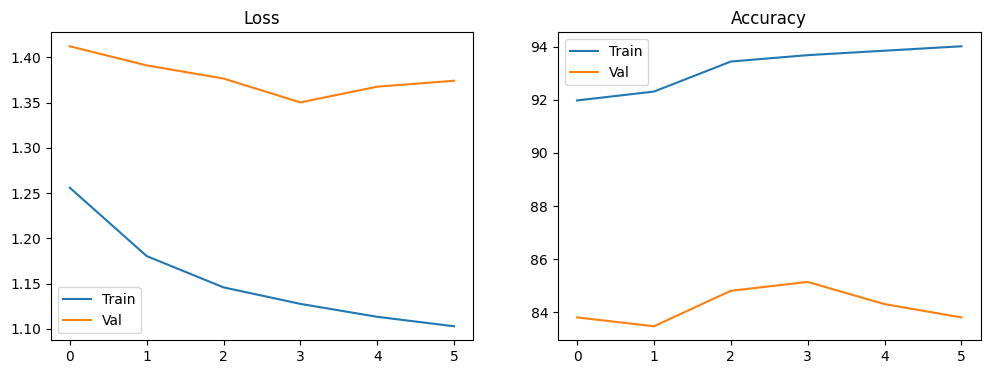

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(history["train_loss"]); plt.plot(history["val_loss"]); plt.title("Loss"); plt.legend(["Train","Val"])
plt.subplot(1,2,2); plt.plot(history["train_acc"]); plt.plot(history["val_acc"]); plt.title("Accuracy"); plt.legend(["Train","Val"])
plt.show()


In [23]:
from peft import PeftModel
from transformers import ViTForImageClassification
import torch, os
from tqdm.auto import tqdm

best_model_dir = f"{save_dir}/best_model"
assert os.path.exists(best_model_dir), "❌ Best model not found — please train first!"

# Load base model with correct number of labels
base_model = ViTForImageClassification.from_pretrained(
    MODEL_NAME, num_labels=num_classes, ignore_mismatched_sizes=True
).to(DEVICE)

# Load LoRA adapters
model = PeftModel.from_pretrained(base_model, best_model_dir)
model.to(DEVICE)
model.eval()

print("✅ Model loaded successfully for testing!")

criterion = nn.CrossEntropyLoss()
test_correct, test_total, test_loss = 0, 0, 0.0

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(pixel_values=imgs)
        logits = outputs.logits
        preds = logits.argmax(dim=1)
        loss = criterion(logits, labels)
        test_correct += (preds == labels).sum().item()
        test_total += imgs.size(0)
        test_loss += loss.item() * imgs.size(0)

test_acc = (test_correct / test_total) * 100.0
test_loss = test_loss / test_total

print(f"\n✅ Final Test Accuracy: {test_acc:.2f}% | Test Loss: {test_loss:.4f}")

# Save metrics
with open(os.path.join(save_dir, "test_metrics.txt"), "w") as f:
    f.write(f"test_loss: {test_loss:.6f}\n")
    f.write(f"test_acc_percent: {test_acc:.2f}\n")

print(f"📁 Results saved to: {save_dir}/test_metrics.txt")



Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully for testing!


Testing:   0%|          | 0/182 [00:00<?, ?it/s]


✅ Final Test Accuracy: 85.09% | Test Loss: 0.6737
📁 Results saved to: /content/drive/MyDrive/vit_lora_output/test_metrics.txt


In [24]:
# Cell A: Try to enable eager attention implementation and run Attention Rollout
import math, cv2, numpy as np
from PIL import Image
import torch

# Helper: attempt to set attn implementation on multiple possible objects
def set_eager_attn_impl(model):
    tried = []
    for candidate in (model, getattr(model, "base_model", None), getattr(getattr(model, "base_model", None), "vit", None), getattr(model, "vit", None)):
        if candidate is None:
            continue
        tried.append(candidate.__class__.__name__)
        if hasattr(candidate, "set_attn_implementation"):
            candidate.set_attn_implementation("eager")
            print(f"set_attn_implementation('eager') on {candidate.__class__.__name__}")
            return True
    print("Tried setting attn implementation on:", tried)
    print("Couldn't find set_attn_implementation on model wrappers; attention outputs may still be unavailable.")
    return False

# Attempt to enable eager attention
set_eager_attn_impl(model)

# Attention rollout functions (same as earlier but safer checks)
def attention_rollout(attentions):
    joint_attentions = None
    for attn in attentions:
        # attn: (batch, heads, seq, seq)
        attn_heads_fused = attn.mean(dim=1)  # average heads -> (batch, seq, seq)
        I = torch.eye(attn_heads_fused.size(-1), device=attn_heads_fused.device).unsqueeze(0).repeat(attn_heads_fused.size(0), 1, 1)
        attn_heads_fused = attn_heads_fused + I
        attn_heads_fused = attn_heads_fused / attn_heads_fused.sum(dim=-1, keepdim=True)
        if joint_attentions is None:
            joint_attentions = attn_heads_fused
        else:
            joint_attentions = attn_heads_fused.bmm(joint_attentions)
    return joint_attentions

def generate_rollout_map_attention(model, img_tensor, image_size=IMAGE_SIZE):
    """
    img_tensor: normalized tensor CxHxW
    returns: heatmap HxW numpy (0..1)
    """
    model.eval()
    # forward with output_attentions=True
    with torch.no_grad():
        outputs = model(pixel_values=img_tensor.unsqueeze(0).to(DEVICE), output_attentions=True)
    attentions = outputs.attentions
    if attentions is None:
        return None  # signal failure
    joint = attention_rollout(attentions)  # (batch, seq, seq)
    cls_attn = joint[0, 0, 1:]   # cls -> patch
    num_patches = cls_attn.shape[0]
    side = int(math.sqrt(num_patches))
    if side * side != num_patches:
        side = int(math.sqrt(num_patches))  # attempt anyway
    attn_map = cls_attn.reshape(side, side).cpu().numpy()
    attn_map = attn_map - attn_map.min()
    if attn_map.max() > 0:
        attn_map = attn_map / attn_map.max()
    attn_map = cv2.resize(attn_map, (image_size, image_size))
    return attn_map

def overlay_heatmap(img_tensor, heatmap, fe=feature_extractor, alpha=0.5):
    mean = np.array(fe.image_mean).reshape(3,1,1)
    std  = np.array(fe.image_std).reshape(3,1,1)
    img = img_tensor.cpu().numpy()
    img = (img * std + mean)
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8).transpose(1,2,0)
    heat_col = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heat_col, alpha, img, 1-alpha, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    return Image.fromarray(overlay)

# Try generating rollout overlays for 6 random test images
os.makedirs(f"{save_dir}/explain_rollout", exist_ok=True)
n_samples = 6
failed = 0
for i in range(n_samples):
    idx = random.randint(0, len(test_ds)-1)
    img_path, label = test_ds.samples[idx]
    pil = Image.open(img_path).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
    img_tensor = test_tfm(pil) if 'test_tfm' in globals() else test_transform(pil)  # compatibility
    heat = generate_rollout_map_attention(model, img_tensor)
    if heat is None:
        print(f"[{i}] Attention rollout not available (attention is None). Falling back to ViT-CAM in a later cell.")
        failed += 1
        continue
    ov = overlay_heatmap(img_tensor, heat)
    ov.save(f"{save_dir}/explain_rollout/explain_rollout_{i}.png")
    print(f"Saved: {save_dir}/explain_rollout/explain_rollout_{i}.png")

if failed == n_samples:
    print("All attention-rollout attempts failed -> run the ViT-CAM fallback cell next.")
else:
    print("Done. Some rollout overlays saved.")



set_attn_implementation('eager') on PeftModelForSequenceClassification
Saved: /content/drive/MyDrive/vit_lora_output/explain_rollout/explain_rollout_0.png
Saved: /content/drive/MyDrive/vit_lora_output/explain_rollout/explain_rollout_1.png
Saved: /content/drive/MyDrive/vit_lora_output/explain_rollout/explain_rollout_2.png
Saved: /content/drive/MyDrive/vit_lora_output/explain_rollout/explain_rollout_3.png
Saved: /content/drive/MyDrive/vit_lora_output/explain_rollout/explain_rollout_4.png
Saved: /content/drive/MyDrive/vit_lora_output/explain_rollout/explain_rollout_5.png
Done. Some rollout overlays saved.
